In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load your dataset
data = pd.read_csv("/content/creditcard.csv")

# Show first few rows
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [5]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67434 entries, 0 to 67433
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    67434 non-null  int64  
 1   V1      67434 non-null  float64
 2   V2      67434 non-null  float64
 3   V3      67434 non-null  float64
 4   V4      67434 non-null  float64
 5   V5      67434 non-null  float64
 6   V6      67434 non-null  float64
 7   V7      67434 non-null  float64
 8   V8      67434 non-null  float64
 9   V9      67434 non-null  float64
 10  V10     67434 non-null  float64
 11  V11     67434 non-null  float64
 12  V12     67434 non-null  float64
 13  V13     67434 non-null  float64
 14  V14     67434 non-null  float64
 15  V15     67434 non-null  float64
 16  V16     67434 non-null  float64
 17  V17     67434 non-null  float64
 18  V18     67434 non-null  float64
 19  V19     67434 non-null  float64
 20  V20     67434 non-null  float64
 21  V21     67433 non-null  float64
 22

In [6]:
# Missing values
print("\nMissing values in each column:\n", data.isnull().sum())



Missing values in each column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [7]:
# Class distribution
print("\nClass distribution:\n", data['Class'].value_counts())


Class distribution:
 Class
0.0    67264
1.0      169
Name: count, dtype: int64


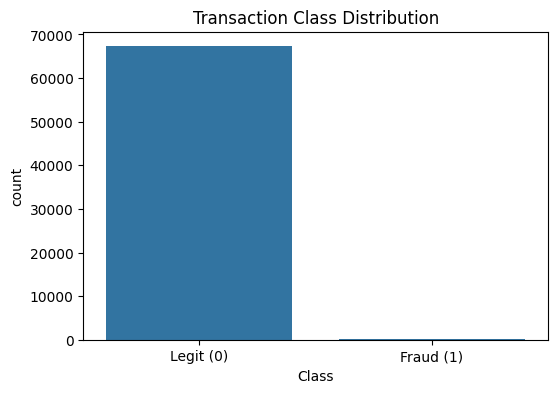

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Class')
plt.title("Transaction Class Distribution")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.show()


In [8]:
# Split data by class
legit = data[data.Class == 0]
fraud = data[data.Class == 1]

# Compare amount statistics
print("Legit Transactions:\n", legit.Amount.describe())
print("\nFraudulent Transactions:\n", fraud.Amount.describe())


Legit Transactions:
 count    67264.000000
mean        96.632489
std        270.008302
min          0.000000
25%          7.680000
50%         26.380000
75%         88.360000
max      19656.530000
Name: Amount, dtype: float64

Fraudulent Transactions:
 count     169.000000
mean       94.895680
std       220.959331
min         0.000000
25%         1.000000
50%         7.610000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64


In [32]:
print(legit.shape)
print(fraud.shape)

(67264, 31)
(169, 31)


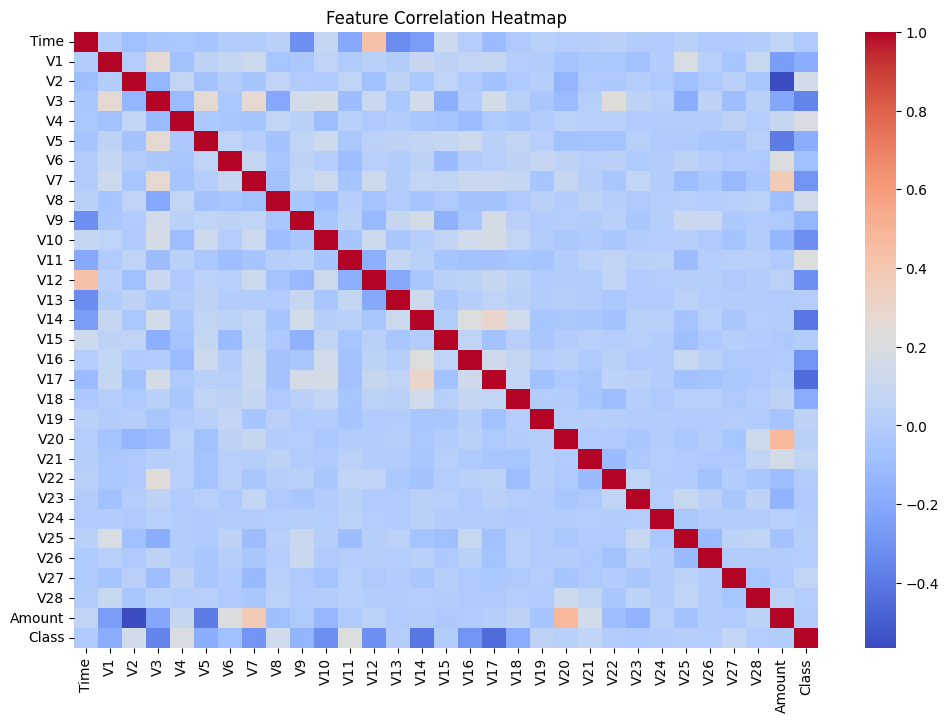

In [9]:
plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [31]:
fraud_count = fraud.shape[0]
legit_sample = legit.sample(n=fraud_count, random_state=1)

balanced_data = pd.concat([legit_sample, fraud], axis=0)
balanced_data = balanced_data.sample(frac=1, random_state=42)  # shuffle

print("New balanced class distribution:\n", balanced_data['Class'].value_counts())


New balanced class distribution:
 Class
0.0    169
1.0    169
Name: count, dtype: int64


In [27]:
X = balanced_data.drop(columns='Class', axis=1)
y = balanced_data['Class']


In [28]:
print(y)

56885    0.0
63421    1.0
6719     1.0
49688    0.0
10568    1.0
        ... 
6820     1.0
2787     0.0
66395    0.0
31002    1.0
11043    0.0
Name: Class, Length: 338, dtype: float64


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training Samples:", X_train.shape)
print("Testing Samples:", X_test.shape)


Training Samples: (270, 30)
Testing Samples: (68, 30)


In [33]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

pipelines = {
    name: ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    for name, model in models.items()
}


In [34]:
for name, pipeline in pipelines.items():
    print(f"\n{'='*40}\nTraining and Evaluating: {name}\n{'='*40}")

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))



Training and Evaluating: Logistic Regression
Confusion Matrix:
 [[34  0]
 [ 3 31]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        34
         1.0       1.00      0.91      0.95        34

    accuracy                           0.96        68
   macro avg       0.96      0.96      0.96        68
weighted avg       0.96      0.96      0.96        68

ROC AUC Score: 0.9558823529411764

Training and Evaluating: Random Forest
Confusion Matrix:
 [[34  0]
 [ 1 33]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        34
         1.0       1.00      0.97      0.99        34

    accuracy                           0.99        68
   macro avg       0.99      0.99      0.99        68
weighted avg       0.99      0.99      0.99        68

ROC AUC Score: 0.9852941176470589

Training and Evaluating: XGBoost
Confusion Matrix:
 [[34  0]
 [ 2

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy on Test Data: {acc:.4f}")


Logistic Regression - Accuracy on Test Data: 0.9559
Random Forest - Accuracy on Test Data: 0.9853
XGBoost - Accuracy on Test Data: 0.9706


In [38]:
import joblib


In [39]:
best_model = pipelines["Random Forest"]


In [40]:
joblib.dump(best_model, "random_forest_model.pkl")


['random_forest_model.pkl']

In [41]:
loaded_model = joblib.load("random_forest_model.pkl")
